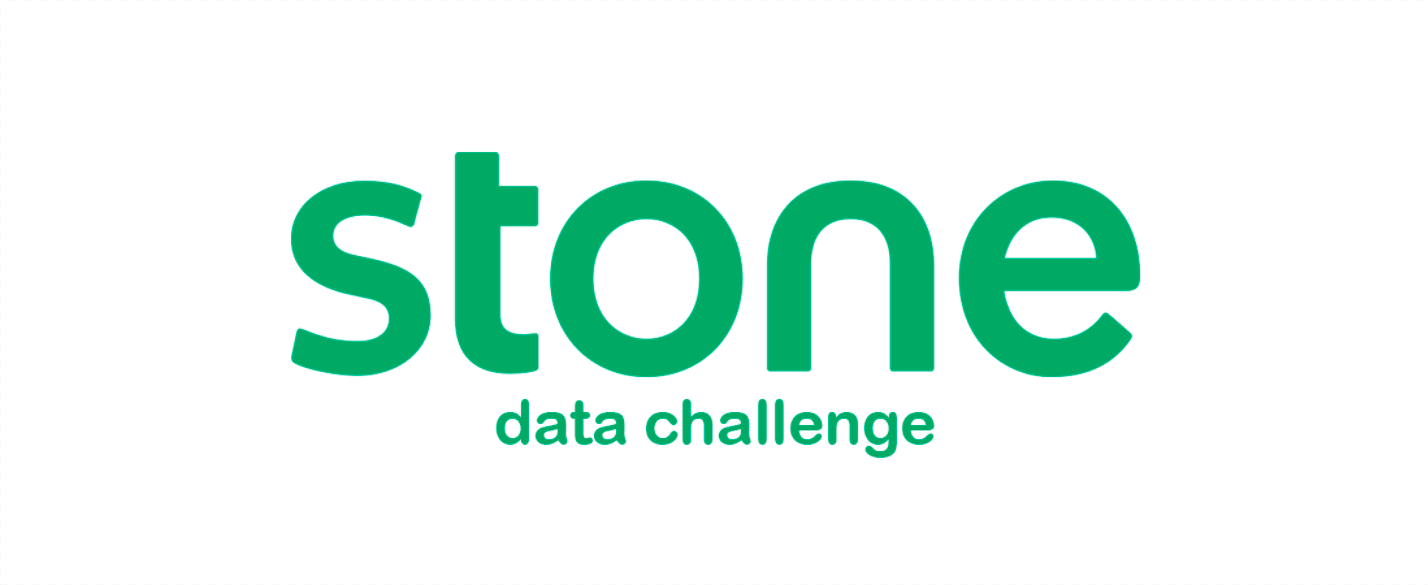

Esse notebook serviu para dar a **primeira olhada** nos datasets e realizar o primeiro **pré-processamento e a limpeza dos dados**. Devido ao volume e aos tipos dos dados - mais de 200mil observações contendo muitas strings no `cadastrais.csv` - ele demora um pouco pra rodar, mas nada muito expressivo (aproximadamente 3min30s).
<br>

O script resultante desse notebook é chamado `cleaning-script.py` e faz o mesmo processo de limpeza, retornando os mesmos 3 DataFrames finais.

### **Resumo do que foi realizado:**

* **`tpv-mensais-treinamento.csv`**
    * **Exploração inicial do dataset**
    * **Parsing nos dados contedo datas**  
    * **Investigação sobre os TPVs Negativos em alguns IDs**
        * Criação de hipóteses para tentar entender o problema
        * Alteração dos TPVs Negativos para a Média de todos os TPVs do dado ID
        
    * **Análise dos Outliers**     


* **`cadastrais.csv`**
    * **Exploração inicial do dataset**
    * **Remoção dos IDs que não estavam no primeiro dataset**
    * **Reorganização dos IDs que possuíam multiplas observações** 
        * Criação de hipóteses para tentar entender o problema
        * GroupBy c/ FowardFill para preencher dados NaNs que estavam preenchidos em observações antigas
        * Troca dos variáveis de datas (`StoneCreatedDate` & `StoneFirstTransactionDate`) nas observações atuais para os primeiros dados - dessa forma, temos as datas originais da criação e primeira venda da conta, além de resolver problemas com IDs recriados a partir da data do desafio.
    * **Padronização do Nome dos Estados**
    * **Investigação dos NaNs restantes após o FFill**
        * Fillna c/ 'Missing Values'
    * **Análise dos Outliers na coluna TPVEstimate**
        * Criação de hipóteses para tentar entender o problema
        * Comparação com os TPV_Mensais
        * Criação de .csv com os dados comparativos

## Iniciando o notebook

In [1]:
# Import libs

# Wranglind and Analysis
import pandas as pd
import numpy as np
import datetime

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
import scipy.stats as st

from helper import dict_estados, YmD_to_datetime, sample_ci_95

In [2]:
# Import nos datasets
cadastrais = pd.read_csv('data/cadastrais.csv', parse_dates = ['StoneCreatedDate', 'StoneFirstTransactionDate'])
tpv_mensais = pd.read_csv('data/tpv-mensais-treinamento.csv', parse_dates = ['mes_referencia'])

# Styling dos plots e dos DataFrames
sns.set_style('white')
sns.set_context('talk')
plt.rc("axes.spines", top=False, right=False)

pd.options.display.float_format = '{:,.2f}'.format
pal = sns.color_palette('colorblind')

## Conhecendo os dados

In [3]:
cadastrais

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
0,76217,2019-12-13,20191220,"7,531.00",Serviços,Autopeças e Serviços Automotivos,Oficinas Automotivas,SMB - Pequeno Porte e Ticket Medio,10k-25k,"15,000.00",PJ,SP
1,78522,2019-04-25,20190508,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,Outro,5k-10k,0.00,PJ,MT
2,79718,2019-10-04,20191017,"7,538.00",Serviços,Autopeças e Serviços Automotivos,Oficinas Automotivas,SMB - Pequeno Porte e Ticket Medio,5k-10k,"8,050.00",MEI,RJ
3,62019,2019-12-20,20191221,"5,451.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"25,000.00",PJ,MG
4,65068,2018-10-23,20181026,"5,462.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Grande Porte e Ticket Baixo,100k-500k,"280,000.00",PJ,RS
...,...,...,...,...,...,...,...,...,...,...,...,...
254358,97825,2018-08-10,20181008,"5,921.00",Alimentação,Alimentação e Bebidas,Comércio de Bebidas,Outro,10k-25k,0.00,PJ,NaN
254359,98042,2018-03-28,20180407,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,Outro,25k-50k,"30,000.00",PJ,SP
254360,205517,2019-09-21,20190925,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,5k-10k,"7,650.00",PF,SP
254361,73433,2020-03-05,20200306,"5,921.00",Alimentação,Alimentação e Bebidas,Comércio de Bebidas,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"20,000.00",MEI,SP


In [4]:
# Primeigo ignorar o TPV
tpv_mensais

,id,mes_referencia,TPV_mensal
0,1,2018-12-31,"10,107.90"
1,1,2019-01-31,"6,023.15"
2,1,2019-02-28,"4,347.30"
3,1,2019-03-31,"9,769.75"
4,1,2019-04-30,"6,701.70"
...,...,...,...
3066767,206329,2020-07-31,"60,213.99"
3066768,206330,2020-04-30,104.50
3066769,206330,2020-05-31,"18,335.62"
3066770,206330,2020-06-30,"15,098.04"


In [5]:
display(tpv_mensais.columns)

display(cadastrais.columns)

Index(['id', 'mes_referencia', 'TPV_mensal'], dtype='object')

Index(['id', 'StoneCreatedDate', 'StoneFirstTransactionDate', 'MCC',
       'MacroClassificacao', 'segmento', 'sub_segmento', 'persona', 'porte',
       'TPVEstimate', 'tipo_documento', 'Estado'],
      dtype='object')

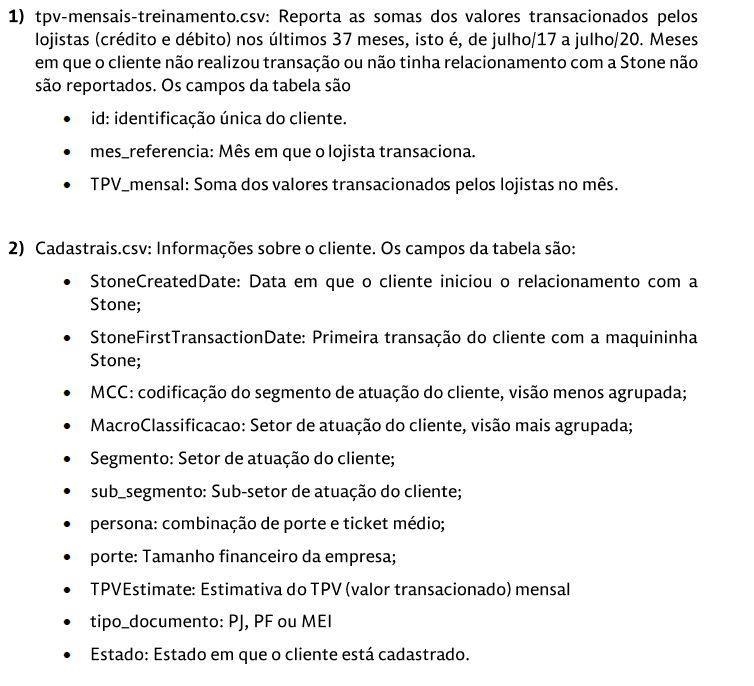

## TPV-Mensais

### Exploração Inicial

In [6]:
# assert no datetime

tpv_mensais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066772 entries, 0 to 3066771
Data columns (total 3 columns):
id                int64
mes_referencia    datetime64[ns]
TPV_mensal        float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 70.2 MB


In [7]:
# checando nulls
tpv_mensais.isnull().sum()

id                0
mes_referencia    0
TPV_mensal        0
dtype: int64

In [8]:
tpv_mensais.describe()

,id,TPV_mensal
count,"3,066,772.00","3,066,772.00"
mean,"100,746.15","23,135.30"
std,"61,981.23","56,928.53"
min,1.00,"-75,084.11"
25%,"46,311.00","4,860.70"
50%,"94,546.00","11,767.00"
75%,"159,672.00","26,445.56"
max,"206,330.00","31,940,981.51"


In [9]:
tpv_mensais.nunique()

id                 205833
mes_referencia         37
TPV_mensal        1995938
dtype: int64

#### Describe - notáveis

1. TPV Mensal negativo?
2. R$ 31,940,981.51? Existem outras vendas altas nesse nível? As outras vendas da empresa são assim mesmo?
3. Outliers completamente desbalanceados <- se ligar
4. STD Maior que o terceiro quartil
5. 205,833 ids únicos 

#### Sobre o DF
* Sem nulos
* mes_referencia tem que ser mudado pra datetime

In [10]:
# Checando se existe alguma não-conformidade no mes-referencia

tpv_mensais['mes_referencia'].min()

Timestamp('2017-07-31 00:00:00')

In [11]:
tpv_mensais['mes_referencia'].max()

Timestamp('2020-07-31 00:00:00')

### TPV_mensal negativo 

In [12]:
# TPV negativo não existe - vamos checar

tpv_mensais[tpv_mensais['TPV_mensal'] < 0]

,id,mes_referencia,TPV_mensal
1621,103,2020-04-30,"-1,189.25"
8058,483,2020-04-30,"-8,119.40"
12212,710,2020-04-30,"-1,270.90"
21396,1242,2018-11-30,-264.01
21397,1242,2018-12-31,"-4,357.34"
...,...,...,...
3016107,203113,2019-07-31,-917.80
3024803,203666,2019-02-28,"-1,360.00"
3037459,204411,2018-06-30,"-1,136.37"
3064717,206179,2018-11-30,-149.00


In [13]:
# 499 rows - bastante coisa pra investigar uma a uma, mas pouca pro tamanho do dataset

tpv_mensais[tpv_mensais['TPV_mensal'] < 0].nunique()

id                435
mes_referencia     37
TPV_mensal        472
dtype: int64

In [14]:
# Quase todos são ids unicos e estão em todos os 37 meses

np.random.seed(42)
ids_com_tpv_menor_que_zero = tpv_mensais[tpv_mensais['TPV_mensal'] < 0]['id'].unique()

# size = 5 pra ficar menos poluído - aumentar é interessante para análise

random_ids = np.random.choice(ids_com_tpv_menor_que_zero, size = 5) 

C:\Users\bueni\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


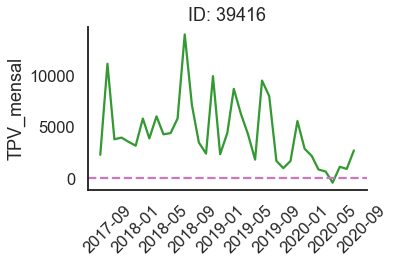

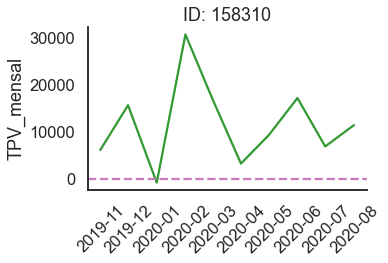

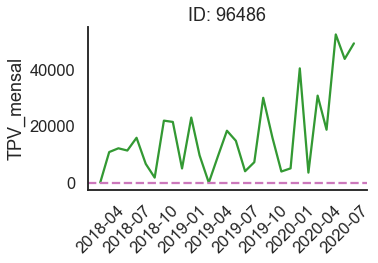

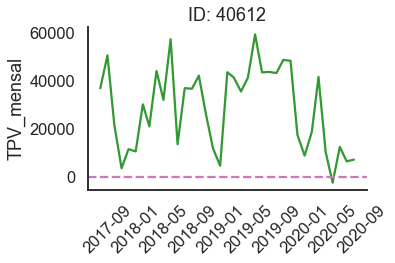

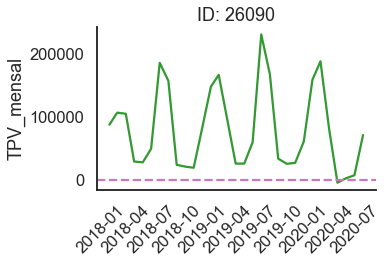

In [15]:
# Plot do TPV em alguns ids que tiveram valores abaixo de zero

for empresa_id in random_ids:
    
    fig, ax = plt.subplots(figsize = (5,3))
    
    sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais[tpv_mensais['id'] == empresa_id],
                 ax = ax, color = 'g', alpha = 0.8)
    
    ax.axhline(y=0, xmin=0, xmax=1, c = pal[4], linestyle="--", alpha = 1)
    plt.xticks(rotation=45)
    ax.set(title = f"ID: {empresa_id}",
           xlabel = '')
    
    plt.show()
    

Sobre o TPV abaixo de zero:

Posso estar perdendo algo aqui, mas não encontrei motivos para o TPV ser negativo. Normalmente, pediria ajuda pra alguém da área - mas é um desafio e não há muito tempo. Possíveis soluções:

* **Fill com 0**
    * Reduz o problema inicial - mas trata os erros como outros TPVs = 0
* **Fill com média dos valores mais próximos**
    * Problema: Empresas com múltiplos valores negativos seguidos
* **Valor absoluto**:
    * Não acho que seja uma solução válida sem saber o problema real
* **Fill com média de todos os valores mensais da empresa**
    * Reduzo problema inicial tb - mas e se tiver motivo pra esses TPVs estarem negativos?

In [16]:
tpv_mensais_modified = tpv_mensais.copy()

In [17]:
# TPV < 0 = mean(TPV_tds_meses)

for empresa_id in ids_com_tpv_menor_que_zero:
    for index, row in tpv_mensais_modified[tpv_mensais_modified['id'] == empresa_id].iterrows():
        if row['TPV_mensal'] < 0:
                tpv_mensais_modified.iloc[index, 2] = np.mean(tpv_mensais_modified[tpv_mensais_modified['id'] == empresa_id]['TPV_mensal'])  

In [18]:
tpv_mensais_modified[tpv_mensais_modified['TPV_mensal'] < 0]              

,id,mes_referencia,TPV_mensal
2163469,151460,2017-08-31,-577.94
2717344,184854,2017-08-31,"-1,090.64"
2780892,188600,2017-08-31,"-1,101.48"


In [19]:
# TPV < 0 = mean(TPV_meses_proximos)
# Existem empresas com múltiplos valores negativos seguidos - XXX
# Função tá aqui pra possível uso futuro

# =============================================================================


# for id in ids_com_tpv_menor_que_zero:
#     for index, row in tpv_mensais_modified[tpv_mensais_modified['id'] == id].iterrows():
#         if row['TPV_mensal'] < 0:
#             if (row['mes_referencia'] != '2020-07-31') and (row['mes_referencia'] != '2017-07-31'):
#                 tpv_mensais_modified.iloc[index, 2] =  np.mean([tpv_mensais_modified.iloc[index - 1]['TPV_mensal'],
#                                                                 tpv_mensais_modified.iloc[index + 1]['TPV_mensal']])

#             if row['mes_referencia'] == '2020-07-31':
#                 tpv_mensais_modified.iloc[index, 2] = np.mean([tpv_mensais_modified.iloc[index - 1]['TPV_mensal'],
#                                                               tpv_mensais_modified.iloc[index - 2]['TPV_mensal']])

#             if row['mes_referencia'] != '2020-07-31':
#                 tpv_mensais_modified.iloc[index, 2] = np.mean([tpv_mensais_modified.iloc[index + 1]['TPV_mensal'],
#                                                                tpv_mensais_modified.iloc[index + 2]['TPV_mensal']])

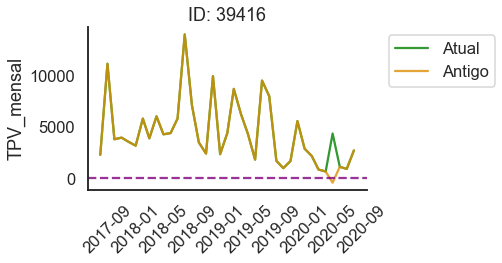

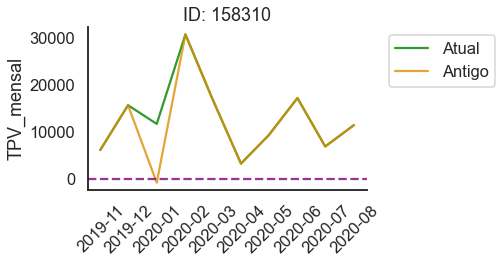

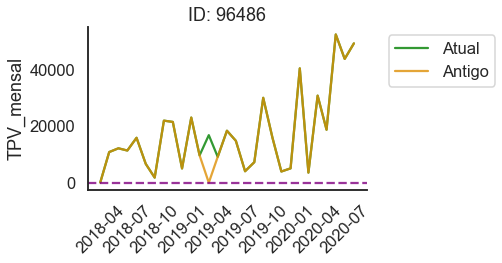

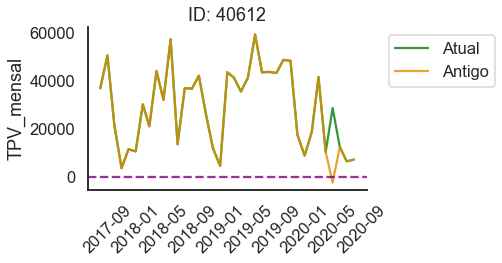

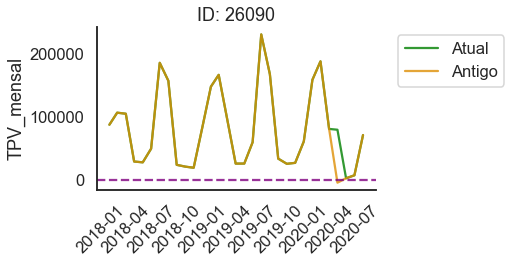

In [20]:
for empresa_id in random_ids:
    
    fig, ax = plt.subplots(figsize = (5,3))
    
    sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais_modified[tpv_mensais_modified['id'] == empresa_id],
                 ax = ax, color = 'g', alpha = 0.8, label = "Atual")
    
    sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais[tpv_mensais['id'] == empresa_id],
                 ax = ax, color = pal[1], alpha = 0.8, label = "Antigo")
    
    ax.axhline(y=0, xmin=0, xmax=1, c = 'purple', linestyle="--", alpha = 0.8)
    plt.xticks(rotation=45)
    ax.set(title = f"ID: {empresa_id}",
           xlabel = '')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

Resolvido o problema dos TPVs negativos, vamos verificar a posssível existência de outliers.

### Outliers

In [21]:
tpv_mensais_modified[tpv_mensais_modified['TPV_mensal'] == tpv_mensais_modified['TPV_mensal'].max()]

,id,mes_referencia,TPV_mensal
472221,28587,2019-04-30,"31,940,981.51"


(array([736573., 736695., 736815., 736938., 737060., 737180., 737303.,
        737425., 737546., 737669.]),
 <a list of 10 Text major ticklabel objects>)

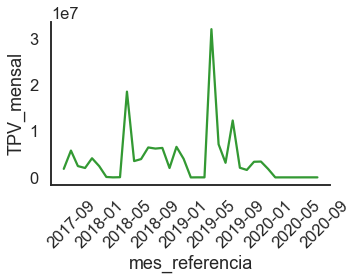

In [22]:
fig, ax = plt.subplots(figsize = (5,3))
    
sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais[tpv_mensais['id'] == 28587],
             ax = ax, color = 'g', alpha = 0.8)
    
plt.xticks(rotation=45)

Apesar do TPV de Abr/2019 dessa empresa ser o maior do dataset, dá pra ver que em Abr/2018 o mesmo aconteceu - o que poderia ser melhor explicado sabendo o ramo da empresa. O valor realmente é um outlier, mas não me parece ser nada de errado. Dá pra perceber que possívelmente foi trocado a plataforma de pagamento também em 2020.

**Lembrar de escalonar para modelos lineares ou não baseados em árvore (SVCs, LR, NN)**

## Cadastrais

### Exploração Inicial

In [23]:
cadastrais.sample(5)

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
4298,52017,2018-06-08,20180608,"5,812.00",Alimentação,Alimentação e Bebidas,Bares e Restaurantes,SMB - Grande Porte e Ticket Baixo,100k-500k,"240,000.00",PJ,SP
205059,138238,2020-03-16,20200317,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"5,001.00",MEI,SP
87307,91370,2017-11-23,20180204,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,Outro,2.5k-5k,0.00,PJ,Amazonas
231822,113625,2019-01-18,20190126,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,SMB - Medio Porte e Ticket Baixo,25k-50k,"30,000.00",PJ,RJ
142306,124597,2020-09-22,0,"5,611.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"10,000.00",PJ,BA


In [24]:
print(f"Número de linhas: {cadastrais.shape[0]} \nNúmero de colunas: {cadastrais.shape[1]}")

Número de linhas: 254363 
Número de colunas: 12


In [25]:
cadastrais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254363 entries, 0 to 254362
Data columns (total 12 columns):
id                           254363 non-null int64
StoneCreatedDate             253901 non-null datetime64[ns]
StoneFirstTransactionDate    253901 non-null object
MCC                          253901 non-null float64
MacroClassificacao           251844 non-null object
segmento                     251844 non-null object
sub_segmento                 251844 non-null object
persona                      253901 non-null object
porte                        253901 non-null object
TPVEstimate                  253901 non-null float64
tipo_documento               253901 non-null object
Estado                       246098 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 23.3+ MB


In [26]:
cadastrais.isnull().sum()

id                              0
StoneCreatedDate              462
StoneFirstTransactionDate     462
MCC                           462
MacroClassificacao           2519
segmento                     2519
sub_segmento                 2519
persona                       462
porte                         462
TPVEstimate                   462
tipo_documento                462
Estado                       8265
dtype: int64

In [27]:
cadastrais.describe()

,id,MCC,TPVEstimate
count,"254,363.00","253,901.00","253,901.00"
mean,"101,915.07","5,883.69","86,096.72"
std,"59,668.97","1,158.41","25,818,536.38"
min,1.00,0.00,0.00
25%,"50,074.50","5,462.00","8,000.00"
50%,"101,063.00","5,714.00","12,000.00"
75%,"153,701.50","5,949.00","25,000.00"
max,"206,330.00","9,950.00","12,996,174,943.00"


In [28]:
cadastrais.describe(include = ["object", "category"])

,StoneFirstTransactionDate,MacroClassificacao,segmento,sub_segmento,persona,porte,tipo_documento,Estado
count,253901,251844,251844,251844,253901,253901,253901,246098
unique,2799,8,29,81,13,8,3,61
top,0,Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Medio,10k-25k,PJ,SP
freq,24295,70659,70659,33089,49107,90644,184492,64674


In [29]:
cadastrais.min()

id                                    1
StoneCreatedDate    1990-01-01 00:00:00
MCC                                0.00
TPVEstimate                        0.00
dtype: object

Problemas até o momento:

* **Mais linhas que o número de IDs**
    * Ids repetidos? O join com o tpv_mensais já arrumaria o problema?
* **Parse do StoneFirstTransactionDate deu errado**
    * Min StoneFirstTransactionDate em 1990**
* **Muitos valores nulos - 1% em alguns categóricos**
    * Espero que seja apenas nos repetidos 
* **61 Valores de Estados**
* **Valor máximo do TPVEstimate - 13Bi**
* **STD absurdamente alto (prob por causa do valor máximo?)**

### Cleaning - Problemas definidos

#### Mais linhas que o número de IDs

In [30]:
cadastrais.id.nunique()

206330

Como o desafio tem um propósito definido e o tempo é relativamente curto, vou cortar desse dataset todos os ids que não estão no tpv_mensais e dar uma olhada novamente nas mesmas coisas acima.

In [31]:
cadastrais_modified = cadastrais.copy()

cadastrais_modified = cadastrais_modified[cadastrais_modified['id'].isin(tpv_mensais.id.unique())]

In [32]:
print(f"Número de linhas: {cadastrais_modified.shape[0]} \nNúmero de colunas: {cadastrais_modified.shape[1]}")

Número de linhas: 253857 
Número de colunas: 12


In [33]:
cadastrais_modified.info()

print("\n===============\nNaNs:")
cadastrais_modified.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253857 entries, 0 to 254362
Data columns (total 12 columns):
id                           253857 non-null int64
StoneCreatedDate             253857 non-null datetime64[ns]
StoneFirstTransactionDate    253857 non-null object
MCC                          253857 non-null float64
MacroClassificacao           251818 non-null object
segmento                     251818 non-null object
sub_segmento                 251818 non-null object
persona                      253857 non-null object
porte                        253857 non-null object
TPVEstimate                  253857 non-null float64
tipo_documento               253857 non-null object
Estado                       246072 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 25.2+ MB

NaNs:


id                              0
StoneCreatedDate                0
StoneFirstTransactionDate       0
MCC                             0
MacroClassificacao           2039
segmento                     2039
sub_segmento                 2039
persona                         0
porte                           0
TPVEstimate                     0
tipo_documento                  0
Estado                       7785
dtype: int64

In [34]:
cadastrais_modified.describe()

,id,MCC,TPVEstimate
count,"253,857.00","253,857.00","253,857.00"
mean,"101,816.22","5,884.07","86,107.00"
std,"59,637.21","1,157.35","25,820,773.75"
min,1.00,0.00,0.00
25%,"50,024.00","5,462.00","8,000.00"
50%,"100,937.00","5,714.00","12,000.00"
75%,"153,509.00","5,949.00","25,000.00"
max,"206,330.00","9,950.00","12,996,174,943.00"


Alguns dos nulos foram eliminados, mas infelizmente esse corte não foi tão efetivo eu gostaria que fosse. 
* Os problemas ainda seguem os mesmos.

Vou tentar entender melhor o problema dos ids repetidos:

In [35]:
# Checando se são apenas duplicados ou múltiplos iguais
cadastrais_modified[cadastrais_modified.duplicated('id', keep = False)]['id'].value_counts()

5695      13
200009    11
40671     10
22574      9
23184      9
          ..
51824      2
143983     2
8813       2
135787     2
22059      2
Name: id, Length: 41060, dtype: int64

In [36]:
# Quantos duplicados tem por 
cadastrais_modified[cadastrais_modified.duplicated('id', keep = False)]['id'].value_counts().value_counts()

2     35387
3      4726
4       721
5       155
6        49
7        11
9         4
8         4
13        1
11        1
10        1
Name: id, dtype: int64

In [37]:
cadastrais_modified[cadastrais_modified.duplicated('id', keep = False)].sort_values(['id', 'StoneCreatedDate']).head(10)

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
166484,21,2018-06-19,20180626,"5,995.00",Varejo,Petshops e Veterinários,Petshops,SMB - Pequeno Porte e Ticket Medio,10k-25k,"3,000.00",PJ,BA
130681,21,2020-04-07,20210102,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"10,000.00",PJ,BA
185808,29,2015-02-19,20150221,"7,230.00",Serviços,Serviços de Beleza e Estética,Salão de Beleza,SMB - Medio Porte e Ticket Medio,25k-50k,0.00,PJ,DF
237704,29,2017-02-21,20170223,"7,230.00",Serviços,Serviços de Beleza e Estética,Salão de Beleza,SMB - Medio Porte e Ticket Medio,50k-100k,"66,000.00",PJ,DF
219842,30,2015-03-23,20171011,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,Outro,5k-10k,1.00,PJ,Minas Gerais
222212,30,2015-03-23,20150413,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,Outro,5k-10k,0.00,PJ,MG
90530,32,2017-11-21,20171123,"5,533.00",Bens duráveis,Autopeças e Serviços Automotivos,Autopeças e Acessórios,Outro,25k-50k,"30,000.00",PJ,GO
195941,32,2020-05-11,20200512,"5,533.00",Bens duráveis,Autopeças e Serviços Automotivos,Autopeças e Acessórios,SMB - Pequeno Porte e Ticket Alto,10k-25k,"15,000.00",PJ,GO
149949,38,2015-07-27,20150730,"7,997.00",Serviços recorrentes,Esporte e Fitness,Academias e Clubes,SMB - Pequeno Porte e Ticket Alto,5k-10k,0.00,PJ,SP
126689,38,2020-01-07,20200108,"7,997.00",Serviços recorrentes,Esporte e Fitness,Academias e Clubes,SMB - Pequeno Porte e Ticket Alto,5k-10k,"6,000.00",PJ,SP


In [38]:
ids_repetidos = np.array(cadastrais_modified[cadastrais_modified.duplicated('id', keep = 'first')]['id'])

np.random.seed(42)

# size = 5 pra ficar menos poluído - aumentar é interessante para análise

random_ids_repetidos = np.random.choice(ids_repetidos, size = 5) 

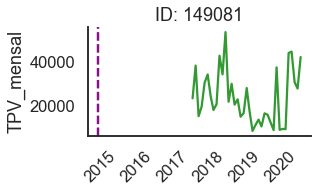

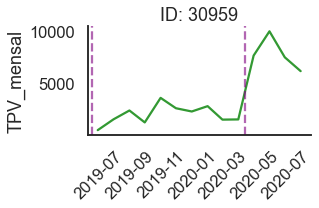

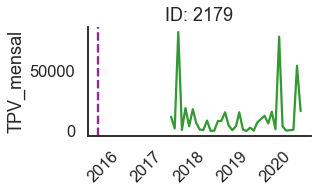

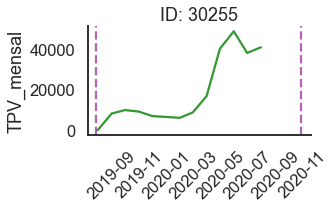

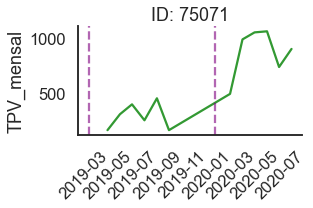

In [39]:
# Checando por anormalidades nos valores doS TPVS de alguns dos duplicados

for empresa_id in random_ids_repetidos:
    fig, ax = plt.subplots(figsize = (4,2))

    sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais[tpv_mensais['id'] == empresa_id],
                 ax = ax, color = 'g', alpha = 0.8)

    for date in cadastrais_modified[cadastrais_modified['id'] == empresa_id]['StoneCreatedDate']:
         ax.axvline(x=date, c = 'purple', linestyle="--", alpha = 0.6)
            
    
    ax.set(title = f"ID: {empresa_id}",
           xlabel = '')
    
    plt.xticks(rotation=45)
    sns.despine()
    sns.set_context('talk')

In [40]:
# Dando uma olhada em uma das empresas que tiveram a data de criação após a data limite

cadastrais_modified[cadastrais_modified.id == 30255]

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
123281,30255,2020-10-28,0,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,SMB - Medio Porte e Ticket Baixo,25k-50k,"10,000.00",PJ,MA
244670,30255,2019-07-26,20190730,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,SMB - Medio Porte e Ticket Baixo,25k-50k,"25,000.00",PJ,MA


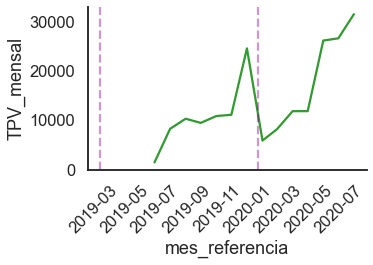

In [41]:
# Checando por anormalidades nos valores dos TPVS da empresa que teve seu ID 13x repetido

fig, ax = plt.subplots(figsize = (5,3))
    
sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = tpv_mensais[tpv_mensais['id'] == 5695],
             ax = ax, color = 'g', alpha = 0.8)

for date in cadastrais_modified[cadastrais_modified['id'] == empresa_id]['StoneCreatedDate']:
         ax.axvline(x=date, c = 'purple', linestyle="--", alpha = 0.4)
    
plt.xticks(rotation=45)

sns.despine()
sns.set_context('talk')

In [42]:
cadastrais_modified[cadastrais_modified.id == 5695]

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
49071,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,SP
49072,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,SP
49073,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,NaN
49074,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,SP
49075,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,SP
49076,5695,2019-06-22,0,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"12,000.00",PJ,SP
136872,5695,2019-06-22,20190626,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"23,000.00",PJ,SP
136873,5695,2019-06-22,20190626,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"23,000.00",PJ,SP
136874,5695,2019-06-22,20190626,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"23,000.00",PJ,SP
136875,5695,2019-06-22,20190626,"5,651.00",Varejo,Moda e Acessórios,Vestuário,SMB - Medio Porte e Ticket Medio,25k-50k,"23,000.00",PJ,SP


Através da análise, a minha hipótese é que:
* **IDs pouco repetidos**: 
    * Atualização/Renovação de Contrato com a Stone
    * Possível troca da máquininha por alguma outra operadora e depois retornou a Stone
* **IDs muito repetidos**:
    * Além das hipóteses acima, erros na entrada dos dados:
        * O ID 5695 possui 13 rows repetidas e a grande maioria delas tem a `StoneCreatedDate` na mesma data
        
Como a ideia é realizar a PREVISÃO de meses seguintes, acredito que os dados mais atuais da empresa sejam os ideais. Além disso, vou também criar uma coluna `tem_duplicados`.

* **Utilizar o groupby com os ids duplicados filtrar as colunas de acordo com os dados**



In [43]:
# datetime errado - vamos investigar

cadastrais_modified['StoneFirstTransactionDate'].min()

'0'

In [44]:
cadastrais_modified[cadastrais_modified['StoneFirstTransactionDate'] == '0']

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado
8,8372,2020-10-07,0,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,SMB - Medio Porte e Ticket Baixo,25k-50k,"10,000.00",PJ,SP
9,8542,2020-04-09,0,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,SMB - Grande Porte e Ticket Baixo,100k-500k,"110,000.00",PJ,GO
14,148660,2016-10-04,0,"5,912.00",Supermercado/Farmácia,"Farmácias, Produtos de Saúde e Cosmética",Drogarias e Farmácias,SMB - Pequeno Porte e Ticket Baixo,5k-10k,0.00,PJ,GO
44,86075,2019-04-11,0,"7,538.00",Serviços,Autopeças e Serviços Automotivos,Oficinas Automotivas,SMB - Medio Porte e Ticket Medio,50k-100k,"30,000.00",PJ,PA
77,171621,2016-03-10,0,"5,462.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,Micro Empreendedor,0-2.5k,0.00,PJ,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
254298,90981,2020-09-18,0,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Pequeno Porte e Ticket Baixo,10k-25k,"10,000.00",PJ,RJ
254329,51194,2020-04-07,0,"5,039.00",Bens duráveis,Materiais de Construção,Materiais de Construção,SMB - Pequeno Porte e Ticket Alto,5k-10k,"10,000.00",PJ,RS
254355,57423,2016-11-25,0,"5,921.00",Alimentação,Alimentação e Bebidas,Comércio de Bebidas,SMB - Medio Porte e Ticket Baixo,25k-50k,0.00,PJ,ES
254356,58223,2019-05-08,0,"5,943.00",Varejo,"Livrarias, Papelarias, Gráficas e Bancas",Livrarias e Papelarias,SMB - Pequeno Porte e Ticket Medio,10k-25k,"25,000.00",PJ,PB


Deu pra perceber que contas com valor zero no `StoneFirstTransactionDate` são de IDs criados ou com as contas recriadas após a data do desafio. Vou utilizar o groupby mapeando com .min para tentar resolver isso também.

Com isso, vai ser possível eliminar os zeros reutilizando dados antigos e manter nas colunas de data a verdadeira data de criação e primeira transação. 

In [45]:
colunas_com_nan = ['MacroClassificacao', 'segmento', 'sub_segmento', 'Estado']

cadastrais_modified = cadastrais_modified.sort_values(['id', 'StoneCreatedDate'])


In [46]:
cadastrais_group_ffill = cadastrais_modified.copy()

# Fill apenas nas colunas c/ NaN ---- Essa função é MUITO lenta

cadastrais_group_ffill[colunas_com_nan] = cadastrais_group_ffill.groupby("id", as_index = False)[colunas_com_nan]\
                                                            .fillna(method='ffill')

In [47]:
# np.where pela eficiencia

cadastrais_group_ffill['tem_duplicados'] = np.where(cadastrais_group_ffill['id'].isin(ids_repetidos), 1, 0)

# Transformar tudo em floats (existem alguns 0 em formato de string)

cadastrais_group_ffill['StoneFirstTransactionDate'] = cadastrais_group_ffill['StoneFirstTransactionDate'].astype(float)

# Retirar o min (anos 90) - pra poder colocar uma data mais atual se tiver no ID
stone_created_min = cadastrais['StoneCreatedDate'].min()

mask_1 = (cadastrais_group_ffill['StoneCreatedDate'] == stone_created_min)
mask_2 = (cadastrais_group_ffill['tem_duplicados'] == 1)

cadastrais_group_ffill.loc[(mask_1 & mask_2), 'StoneCreatedDate'] = datetime.date(2100, 1, 1)

# Exceção - ID c/ 2 rows com anos = 1990

cadastrais_group_ffill.loc[cadastrais_group_ffill['id'] == 46233, 'StoneCreatedDate'] = stone_created_min

# StoneFirstTransactionDate = 0 --> 2222200429 || para poder usar o `min`

cadastrais_group_ffill.loc[: , 'StoneFirstTransactionDate'] = np.where(cadastrais_group_ffill.loc[: , 'StoneFirstTransactionDate'] == 0,
                                                                       2222200429,
                                                                       cadastrais_group_ffill.loc[: , 'StoneFirstTransactionDate'])

date_map = {'StoneCreatedDate': 'min',
            'StoneFirstTransactionDate': 'min'}

# criar as colunas de data 

date_columns = cadastrais_group_ffill.groupby("id", as_index = False).agg(date_map, axis = 1)
date_columns

,id,StoneCreatedDate,StoneFirstTransactionDate
0,1,2018-12-12,"20,181,213.00"
1,2,2020-04-13,"20,200,414.00"
2,3,2019-05-31,"20,190,615.00"
3,4,2017-09-29,"20,171,002.00"
4,5,2019-01-31,"20,190,131.00"
...,...,...,...
205828,206326,2019-05-16,"20,190,520.00"
205829,206327,2020-01-21,"20,200,122.00"
205830,206328,2019-07-15,"20,190,717.00"
205831,206329,2019-12-18,"20,191,226.00"


In [48]:
# StoneCreatedDate = 1990 que sobraram -> StoneFirstTransactionDate
date_columns.loc[date_columns['StoneCreatedDate'] == stone_created_min, 'StoneCreatedDate'] = pd.to_datetime(date_columns[date_columns['StoneCreatedDate'] == stone_created_min]['StoneFirstTransactionDate'].apply(YmD_to_datetime))

In [49]:
cadastrais_group_ffill[(cadastrais_group_ffill['StoneCreatedDate'] == stone_created_min) \
                                       & (cadastrais_group_ffill['tem_duplicados'] == 1)]

,id,StoneCreatedDate,StoneFirstTransactionDate,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados
63792,46233,1990-01-01,"2,222,200,429.00",0.00,NaN,NaN,NaN,Outro,0-2.5k,0.00,PJ,NaN,1
78373,46233,1990-01-01,"20,141,119.00","8,999.00",Serviços,Outros Serviços,Outros Serviços - Outros,Outro,25k-50k,0.00,PJ,NaN,1


In [50]:
# Drop duplicados mantendo apenas as últimas

cadastrais_group_ffill = cadastrais_group_ffill.drop_duplicates('id', keep = 'last').reset_index(drop = True)

# Drop variáveis de data, merge nas novas -> mantendo assim a verdadeira data de criação e primeira transação

cadastrais_group_ffill = cadastrais_group_ffill.drop(['StoneCreatedDate', 'StoneFirstTransactionDate'], axis = 1)
cadastrais_group_ffill = cadastrais_group_ffill.merge(date_columns, on = 'id')

In [51]:
cadastrais_group_ffill.info()

print("\n===============\nNaNs:")
cadastrais_group_ffill.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205833 entries, 0 to 205832
Data columns (total 13 columns):
id                           205833 non-null int64
MCC                          205833 non-null float64
MacroClassificacao           205745 non-null object
segmento                     205745 non-null object
sub_segmento                 205745 non-null object
persona                      205833 non-null object
porte                        205833 non-null object
TPVEstimate                  205833 non-null float64
tipo_documento               205833 non-null object
Estado                       203940 non-null object
tem_duplicados               205833 non-null int32
StoneCreatedDate             205833 non-null datetime64[ns]
StoneFirstTransactionDate    205833 non-null float64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(7)
memory usage: 21.2+ MB

NaNs:


id                              0
MCC                             0
MacroClassificacao             88
segmento                       88
sub_segmento                   88
persona                         0
porte                           0
TPVEstimate                     0
tipo_documento                  0
Estado                       1893
tem_duplicados                  0
StoneCreatedDate                0
StoneFirstTransactionDate       0
dtype: int64

In [52]:
# Como são variáveis categoricas, criarei uma categoria para os valores faltantes

cadastrais_group_ffill.fillna("Missing Value", inplace = True)

Problemas até o momento:

* **Parse do StoneFirstTransactionDate deu errado**
* **Valor máximo do TPVEstimate??? Bilhões???**
* **STD absurdamente alto (prob por causa do valor máximo?)**
* **61 valores de estados**
* ~~Mais linhas que o número de IDs~~
    ~~* Ids repetidos? O join com o tpv_mensais já arrumaria o problema?~~
* ~~Muitos valores nulos - 1% em alguns categóricos~~~~
    ~~* Espero que seja apenas nos repetidos~~ 

In [53]:
cadastrais_group_ffill['Estado'].value_counts()

SP                     53015
RJ                     20563
MG                     18364
PR                     18124
SC                     14732
RS                     13024
BA                      9710
GO                      7668
PE                      6211
DF                      4846
CE                      4645
ES                      4491
PA                      3103
MT                      2736
RN                      2711
MA                      2335
PB                      2212
SE                      2169
Missing Value           1893
AL                      1637
MS                      1604
AM                      1365
São Paulo               1249
RO                       998
PI                       941
TO                       759
Minas Gerais             698
AP                       581
RR                       521
AC                       497
Santa Catarina           456
Paraná                   431
Rio de Janeiro           363
Goiás                    209
Pará          

In [54]:
# Padronizando o nome dos estados
cadastrais_group_ffill['Estado'] = cadastrais_group_ffill['Estado'].replace(dict_estados)

In [55]:
cadastrais_group_ffill['Estado'].value_counts()

SP               54267
RJ               20927
MG               19062
PR               18556
SC               15190
RS               13120
BA                9844
GO                7877
PE                6237
DF                4882
CE                4695
ES                4526
PA                3249
MT                2843
RN                2723
MA                2427
PB                2224
SE                2200
Missing Value     1893
AL                1643
MS                1614
AM                1406
RO                1034
PI                 945
TO                 786
AP                 599
RR                 550
AC                 514
Name: Estado, dtype: int64

#### Parse do StoneFirstTransactionDate

In [56]:
# arrumando a coluna StoneFirstTransactionDate

cadastrais_group_ffill['StoneFirstTransactionDate']  = pd.to_datetime(cadastrais_group_ffill['StoneFirstTransactionDate']\
                                                                      .apply(YmD_to_datetime))

In [57]:
cadastrais_group_ffill.info()

print("\n===============\nNaNs:")
cadastrais_group_ffill.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205833 entries, 0 to 205832
Data columns (total 13 columns):
id                           205833 non-null int64
MCC                          205833 non-null float64
MacroClassificacao           205833 non-null object
segmento                     205833 non-null object
sub_segmento                 205833 non-null object
persona                      205833 non-null object
porte                        205833 non-null object
TPVEstimate                  205833 non-null float64
tipo_documento               205833 non-null object
Estado                       205833 non-null object
tem_duplicados               205833 non-null int32
StoneCreatedDate             205833 non-null datetime64[ns]
StoneFirstTransactionDate    205833 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(7)
memory usage: 21.2+ MB

NaNs:


id                           0
MCC                          0
MacroClassificacao           0
segmento                     0
sub_segmento                 0
persona                      0
porte                        0
TPVEstimate                  0
tipo_documento               0
Estado                       0
tem_duplicados               0
StoneCreatedDate             0
StoneFirstTransactionDate    0
dtype: int64

As variáveis com NaNs restantes - `Estado`, `` e `` são categóricas e os ids que sobraram não possuem nenhum dado antigo para dar ffill. Existem algumas formas diferentes de resolver isso e, por enquanto, deixarei assim - Durante o processamento do dataset para a criação do modelo e, em acordo com o tempo que faltar, eu preencho esses dados.


* **Valor máximo do TPVEstimate??? Bilhões???**
* **STD absurdamente alto (prob por causa do valor máximo?)**
* ~~**61 valores de estados**~~
* ~~Parse do StoneFirstTransactionDate deu errado~~
* ~~Mais linhas que o número de IDs~~
    ~~* Ids repetidos? O join com o tpv_mensais já arrumaria o problema?~~
* ~~Muitos valores nulos - 1% em alguns categóricos~~~~
    ~~* Espero que seja apenas nos repetidos~~ 

#### Valor máximo do TPVEstimate

In [58]:
cadastrais_group_ffill.nlargest(10, 'TPVEstimate')

,id,MCC,MacroClassificacao,segmento,sub_segmento,persona,porte,TPVEstimate,tipo_documento,Estado,tem_duplicados,StoneCreatedDate,StoneFirstTransactionDate
92389,92475,"5,422.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Grande Porte e Ticket Baixo,500k+,"12,996,174,943.00",MEI,SP,0,2019-09-25,2019-09-26
55626,55689,"8,211.00",Serviços recorrentes,Educação,Ensino Básico,Outro,500k+,"300,000,000.00",PJ,SP,1,2017-07-20,2017-08-30
28998,29030,"5,949.00",Bens duráveis,Casa e Decoração,Armarinhos e Tecido,SMB - Grande Porte e Ticket Alto,500k+,"210,000,000.00",PJ,GO,1,2016-04-01,2016-04-06
5863,5868,"5,499.00",Alimentação,Alimentação e Bebidas,Comércio de Alimentos,SMB - Grande Porte e Ticket Baixo,500k+,"150,000,000.00",PJ,SC,1,2016-08-29,2016-12-16
191008,191386,"5,039.00",Bens duráveis,Materiais de Construção,Materiais de Construção,SMB - Grande Porte e Ticket Alto,500k+,"120,000,000.00",PJ,BA,0,2018-10-18,2018-12-04
168956,169205,"5,722.00",Bens duráveis,Eletroeletrônicos,Eletrodomésticos,Outro,500k+,"99,999,999.99",PF,MA,0,2019-11-14,2019-11-19
35144,35181,"5,139.00",Varejo,Moda e Acessórios,Calçados,SMB - Grande Porte e Ticket Medio,500k+,"80,000,000.00",PJ,SP,1,2016-01-27,2015-07-01
194237,194641,"5,541.00",Posto,Postos de Gasolina e Similares,Postos de Gasolina,SMB - Grande Porte e Ticket Baixo,500k+,"70,000,000.00",PJ,PR,0,2019-02-19,2019-02-21
194862,195275,"5,411.00",Supermercado/Farmácia,Supermercados,Supermercados,SMB - Grande Porte e Ticket Baixo,500k+,"50,011,000.00",PF,RN,0,2019-06-07,2019-08-08
150275,150412,"5,065.00",Bens duráveis,Eletroeletrônicos,Eletrônicos,SMB - Grande Porte e Ticket Alto,500k+,"50,000,000.00",PJ,PR,1,2017-12-20,2018-03-01


In [59]:
# TPV_mensal muito baixo para aquela estimativa
tpv_mensais_modified[tpv_mensais_modified['id'] == 92475]

,id,mes_referencia,TPV_mensal
1502963,92475,2019-09-30,"1,006.96"
1502964,92475,2019-10-31,"6,309.61"
1502965,92475,2019-11-30,"8,068.29"
1502966,92475,2019-12-31,"13,432.16"
1502967,92475,2020-01-31,"8,581.67"
1502968,92475,2020-02-29,"10,747.46"
1502969,92475,2020-03-31,"11,561.29"
1502970,92475,2020-04-30,"13,247.51"
1502971,92475,2020-05-31,"18,980.82"
1502972,92475,2020-06-30,"18,098.08"


In [60]:
# Soma total dos 36 meses de dados da empresa abaixo dos 300mi no TPV_estimate

tpv_mensais_modified[tpv_mensais_modified['id'] == 55689].sum()

id             2,004,804.00
TPV_mensal   139,835,497.83
dtype: float64

In [61]:
# Bem abaixo dos 50mi no TPV_estimate

tpv_mensais_modified[tpv_mensais_modified['id'] == 195275]

,id,mes_referencia,TPV_mensal
2891242,195275,2019-08-31,"3,293.89"
2891243,195275,2019-09-30,"7,025.20"
2891244,195275,2019-10-31,"6,168.37"
2891245,195275,2019-11-30,"5,369.17"
2891246,195275,2019-12-31,"5,894.78"
2891247,195275,2020-01-31,"5,397.19"
2891248,195275,2020-02-29,"6,570.62"
2891249,195275,2020-03-31,"7,787.55"
2891250,195275,2020-04-30,"9,948.56"
2891251,195275,2020-05-31,"10,104.88"


De acordo com a documentação do arquivo `cadastrais.csv`, o TPVEstimate é a estimativa do TPV(valor transacionado) mensal. No entanto, alguns dos valores não fazem sentido algum quando comparamos com os dados do `tpv_mensais.csv`. 

* A empresa do TPVEstimate aprox 13bi é um **MEI** - e é sabido que MEIs só podem ter receita anual de 81k. Além disso, nenhuma de seus TPVs mensais pela Stone ultrapassa 21k na tabela `tpv_mensais`.
* A segunda empresa com maior TPVEstimate possui ali valor de 300mi, mas a soma dos 36 meses dos TPV_mensais é igual aprox 140mi.  

Aqui seria mais um momento ideal para falar com quem montou o dataset ou alguém que tenha proficiência sobre o negócio ou sobre como é dada a coleta dessas informações. Como isso não é possível, minha ideia é criar hipóteses e ir de acordo com a mais provável de acordo com os dados.

**Hipóteses**:  
  
* TPVEstimate tem algum outro significado ao invés daquele constado no PDF
    * Apesar de ser uma hipótese válida, eu não tenho como comprovar utilizando os dados.
    * Não poderia ser nem TPV anual, considerando as informações da tabela de tpv_mensais


* Formula utilizada para o cálculo do TPVEstimate contém erros
    * Apesar de ser uma hipótese válida, eu não tenho como comprovar utilizando os dados.


* Erro na entrada desses dados;
    * Se eu fosse pelo instinto, essa seria a mais provável.
    * Alguns dados não fazem sentido algum com a descrição
    
    
* TPVEstimate com erro nas casas decimais
    * Não bate com os dados.

Para tentar entender melhor o problema e descobrir a melhor forma de agir, vou investigar um pouco mais sobre a relação do TPVEstimate e o TPV_mensal.

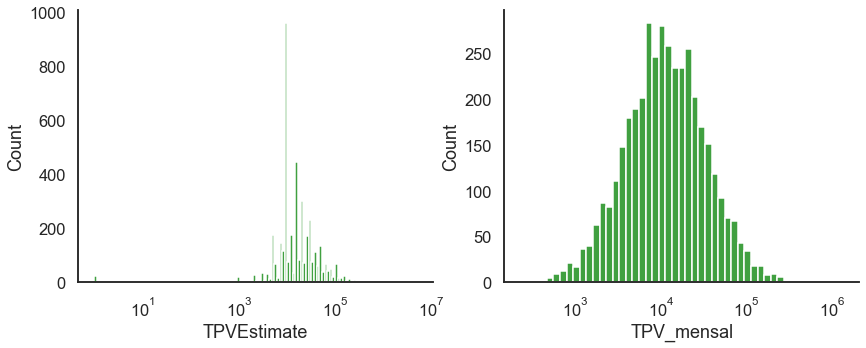

In [62]:
# Seed random
np.random.seed(42)

# Criando apenas uma amostra do cadastrais pro plot
cadastrais_sample = cadastrais_group_ffill[cadastrais_group_ffill['TPVEstimate'] != 0].sample(4000)
sample_ids = np.array(cadastrais_sample['id'])

# Mesmos ids na tpv_mensais
tpv_mensais_sample = tpv_mensais_modified[tpv_mensais_modified['id'].isin(sample_ids)].groupby('id').mean()

# Plot
fig, axs = plt.subplots(1,2, figsize = (14,5))

sns.histplot(x = cadastrais_sample['TPVEstimate'], log_scale=True, color = 'g', ax = axs[0])
sns.histplot(x = tpv_mensais_sample['TPV_mensal'], log_scale=True, color = 'g', ax = axs[1])

A distribuição é relativamente parecida, **se aproximando da normal**, mas o TPVEstimate possui um número maior de outliers que a média do TPV_mensal, além de ter alguns counts bem mais altos que os outros - o que poderia indicar um **arredondamento ou inserção manual dos dados**.   

In [63]:
np.corrcoef(tpv_mensais.groupby('id').mean()['TPV_mensal'], cadastrais_group_ffill['TPVEstimate'])[0, 1]

0.006497201911909061

O coeficiente de correlação Pearson entre as duas váriaveis se aproxima de 0, o que é bem estranho pra mim. Vou calcular o intervalo de confiança para a média do TPV de cada ID (`TPV_mensais`) a partir de um teste T e observar em quantas o TPVEstimate está dentro desse intervalo.

In [64]:
# Essa célula demora um pouquinho pra rodar

# Cria um DataFrame com a média dos TPV_mensais e o TPVEstimate por ID

estimate_and_mean_tpv = tpv_mensais_modified.groupby('id')\
                                            .mean()\
                                            .merge(cadastrais_group_ffill[['id', 'TPVEstimate']], on = 'id')


# Cria um DataFrame com o intervalo de confiança da média dos TPV_mensais por ID

mean_ci = tpv_mensais_modified[['id', 'TPV_mensal']]\
                                .groupby('id')['TPV_mensal']\
                                .apply(sample_ci_95)\
                                .apply(pd.Series)\
                                .rename(columns={0:'TPV_medio_CI_LOW',
                                                 1:'TPV_medio_CI_HIGH'})


# Reorganiza as variáveis, merge em ambos os DFs e cria novas variáveis 'is_estimate_in_CI' e 'diff'

estimate_and_mean_tpv = estimate_and_mean_tpv[['id', 'TPVEstimate', 'TPV_mensal']]

estimate_and_mean_tpv['diff'] = estimate_and_mean_tpv['TPVEstimate'] - estimate_and_mean_tpv['TPV_mensal']

estimate_and_mean_tpv = estimate_and_mean_tpv.merge(mean_ci, on = 'id')

estimate_and_mean_tpv['is_estimate_in_CI'] = np.where(((estimate_and_mean_tpv['TPVEstimate'] >= estimate_and_mean_tpv['TPV_medio_CI_LOW']) &\
                                                      (estimate_and_mean_tpv['TPVEstimate'] <= estimate_and_mean_tpv['TPV_medio_CI_HIGH'])),
                                                      1, 0)                                                    

C:\Users\bueni\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\bueni\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\bueni\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2016: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


In [65]:
estimate_and_mean_tpv

,id,TPVEstimate,TPV_mensal,diff,TPV_medio_CI_LOW,TPV_medio_CI_HIGH,is_estimate_in_CI
0,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
1,2,"10,001.00","20,886.41","-10,885.41","9,395.82","32,377.00",1
2,3,"3,000.00","2,820.00",180.00,"2,248.76","3,391.25",1
3,4,"25,000.00","49,397.54","-24,397.54","44,570.41","54,224.67",0
4,5,"6,000.00","1,076.04","4,923.96",542.13,"1,609.96",0
...,...,...,...,...,...,...,...
205828,206326,"4,000.00","10,245.09","-6,245.09","7,042.94","13,447.24",0
205829,206327,"20,000.00","23,140.29","-3,140.29","6,418.34","39,862.24",1
205830,206328,"2,000.00","4,052.77","-2,052.77","2,811.15","5,294.39",0
205831,206329,"60,000.00","45,437.55","14,562.45","31,549.95","59,325.16",0


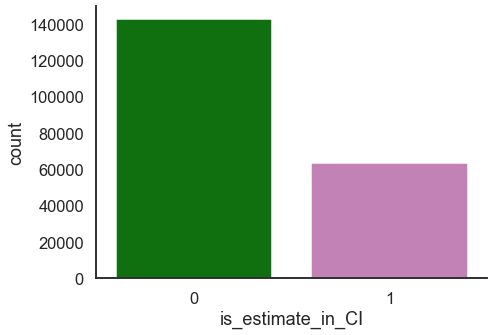

In [66]:
fig, ax = plt.subplots(figsize = (7,5))

sns.countplot(x ='is_estimate_in_CI', data = estimate_and_mean_tpv, palette = ['g', pal[4]])

**Aproximadamente um terço dos valores do TPVEstimate estão dentro do intervalo de confiança da média**, considerando um erro de 5%.  

In [67]:
estimate_and_mean_tpv[abs(estimate_and_mean_tpv['diff']) > (estimate_and_mean_tpv['TPV_mensal'])]

,id,TPVEstimate,TPV_mensal,diff,TPV_medio_CI_LOW,TPV_medio_CI_HIGH,is_estimate_in_CI
0,1,"71,000.00","12,191.67","58,808.33","9,931.27","14,452.08",0
4,5,"6,000.00","1,076.04","4,923.96",542.13,"1,609.96",0
6,7,"11,000.00","3,642.54","7,357.46","2,932.93","4,352.16",0
8,9,"25,000.00","11,849.65","13,150.35","5,242.93","18,456.37",0
10,11,"10,000.00","3,016.09","6,983.91","2,630.28","3,401.91",0
...,...,...,...,...,...,...,...
205822,206320,"13,000.00","6,188.87","6,811.13","4,841.84","7,535.90",0
205823,206321,"5,000.00","1,585.53","3,414.47",927.60,"2,243.47",0
205824,206322,"5,000.00","1,304.17","3,695.83",716.55,"1,891.79",0
205825,206323,"17,800.00","1,205.95","16,594.05",856.70,"1,555.20",0


Em aproximadamente 25% das observações, a diferença do TPVEstimate e o TPV_mensal é maior que o próprio TPV_mensal. 

In [68]:
estimate_and_mean_tpv[estimate_and_mean_tpv['diff'] < 0]

,id,TPVEstimate,TPV_mensal,diff,TPV_medio_CI_LOW,TPV_medio_CI_HIGH,is_estimate_in_CI
1,2,"10,001.00","20,886.41","-10,885.41","9,395.82","32,377.00",1
3,4,"25,000.00","49,397.54","-24,397.54","44,570.41","54,224.67",0
5,6,"37,000.00","49,606.38","-12,606.38","36,753.84","62,458.92",1
7,8,"40,000.00","59,711.75","-19,711.75","49,389.65","70,033.86",0
12,13,"5,000.00","5,132.09",-132.09,"3,779.35","6,484.82",1
...,...,...,...,...,...,...,...
205827,206325,"10,000.00","101,392.16","-91,392.16","52,876.52","149,907.80",0
205828,206326,"4,000.00","10,245.09","-6,245.09","7,042.94","13,447.24",0
205829,206327,"20,000.00","23,140.29","-3,140.29","6,418.34","39,862.24",1
205830,206328,"2,000.00","4,052.77","-2,052.77","2,811.15","5,294.39",0


Considerando todas as informações sobre a variável TPVEstimate, acredito que a melhor decisão é não usar ela para treinar o modelo - considerando que o comportamento dela é quase aleatório ao TPV_mensal real de acordo com o coeficiente pearson.

Com isso, finalizo a limpeza dos dados e vou exportar os datasets.

In [69]:
estimate_and_mean_tpv.to_csv("data/estimativa-e-tpv-medio-ci.csv")
tpv_mensais_modified.to_csv("data/tpv-mensais-limpo.csv")
cadastrais_group_ffill.to_csv("data/cadastrais-limpo.csv")